In [1]:
## Analytical Placement Toy ##

In [20]:
# Step 0-1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from IPython.display import display, clear_output


In [3]:
# Step 0-2: Define Parameters
GAMMA = 1.0
LR    = 0.5
ITER  = 100
num_bins = 16 # grid 16x16
target_density = 1.0

In [4]:
class Netlist:
    def __init__(self):
        self.cells_name    = []
        self.cells_size    = []
        self.cells_pos     = [] # pos is center of cell
        self.nets          = []
        self.cells_isfixed = [] # 1: fixed, 0: movable


In [24]:
# Step 2: Define Util Functions
# Visualize Placements
def plot_placement(ax, board_size, netlist, iteration, costs_info):
    bin_size = board_size / num_bins
    for i in range(num_bins + 1):
        x = i * bin_size
        y = i * bin_size
        ax.axhline(y, color='lightgray', linewidth=0.5, zorder=0)
        ax.axvline(x, color='lightgray', linewidth=0.5, zorder=0)

    for net in netlist.nets:
        net_cells = netlist.cells_pos[net]
        ax.plot(net_cells[:, 0], net_cells[:, 1], 'r--', alpha=0.5)  # Draw nets

    for i, (pos, size) in enumerate(zip(netlist.cells_pos, netlist.cells_size)):
        rect = plt.Rectangle(pos - size / 2, size[0], size[1], edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
        ax.text(pos[0], pos[1], netlist.cells_name[i], ha='center', va='center', fontsize=8, color='blue')

    ax.set_xlim(0, board_size)
    ax.set_ylim(0, board_size)
    # ax.set_title(f'Placement at Iteration {iteration}, WL(LSE/HPWL): {costs_info["total_lse"]:.2f} / {costs_info["total_hpwl"]:.2f}, Overflow(Pot/Den): {costs_info["total_potential_overflow"]:.2f} / {costs_info["total_density_overflow"]:.2f}, Cost(obj/real): {costs_info["total_obj_value"]:.2f} / {costs_info["total_cost"]:.2f}')
    ax.set_title(f'Placement at Iteration {iteration}\n' + 
                 f'  WL: {costs_info["total_lse"]:.2f}, Overflow: {costs_info["total_potential_overflow"]:.2f},    Obj_f: {costs_info["total_obj_value"]:.2f}\n' + 
                 f'  Grad: {costs_info["gWL"]:.2e} + {costs_info["weight_density"]:.2e} * {costs_info["gPot"]:.2e} (Den Ratio: {(costs_info["weight_density"]*costs_info["gPot"]/costs_info["gWL"]):.2e})\n' + 
                 f'HPWL: {costs_info["total_hpwl"]:.2f},  OverDen: {costs_info["total_density_overflow"]:.2f}, RealCost: {costs_info["total_cost"]:.2f}')
    # ax.text(0.5, 0.92, 
    #         f'  WL: {costs_info["total_lse"]:.2f}, Overflow: {costs_info["total_potential_overflow"]:.2f},    Obj_f: {costs_info["total_obj_value"]:.2f}\n' + 
    #         f'HPWL: {costs_info["total_hpwl"]:.2f},  OverDen: {costs_info["total_density_overflow"]:.2f}, RealCost: {costs_info["total_cost"]:.2f}', 
    #      ha='center', fontsize=10)
    ax.grid(False)

# Visualize Density Map
def plot_density_map(fig, ax, board_size, density_map):
    bin_size = board_size / num_bins
    # Draw heat map
    heatmap = ax.imshow(
        density_map.T,              # transpose: make y-axis as vertical
        origin='lower',             # let (0, 0) be at the bottom-left
        extent=[0, board_size, 0, board_size],  # extend to chip size
        cmap='Reds',                # heat map
        aspect='equal'
    )
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label('Density')
    for i in range(num_bins + 1):
        x = i * bin_size
        y = i * bin_size
        ax.axhline(y, color='lightgray', linewidth=0.5, zorder=0)
        ax.axvline(x, color='lightgray', linewidth=0.5, zorder=0)
    ax.set_xlim(0, board_size)
    ax.set_ylim(0, board_size)
    ax.set_title(f'Density Map')
    ax.grid(False)

# # Initialize Placement
# def initialize_placement(num_cells, board_size, isfixed):
#     cells_pos = np.random.rand(num_cells, 2) * board_size  # Random positions within the canvas
#     # random place movable cells at centor area (9/20 ~ 11/20)
#     for i in range(num_cells):
#         # rand float in [0.45, 0.55] * board_size
#         if isfixed[i] == 0:
#             cells_pos[i, 0] = (0.45 + 0.1 * np.random.rand()) * board_size  # x
#             cells_pos[i, 1] = (0.45 + 0.1 * np.random.rand()) * board_size  # y
#     return cells_pos

# Initialize Placement
def initialize_placement(num_cells, board_size, isfixed):
    np.random.seed(666)  # For reproducibility
    cells = np.random.rand(num_cells, 2) * board_size  # Random positions within the canvas
    # random place fixed cells at centor area (1/4 ~ 3/4)
    # for i in range(num_cells):
    #     if isfixed[i]:
    #         cells[i] = np.random.rand(2) * board_size * 0.5 + board_size * 0.25
    return cells

In [32]:
# Test Case
# Assume we have 5 cells and 4 nets connecting them
board_size = 32
netlist = Netlist()
netlist.cells_name = ['A', 'B', 'C', 'D', 'E', 'F', 'f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10']
netlist.cells_size = np.array([[3,3], [3,3], [1,2], [2,1], [1,1], [1,1], [3,3], [3,3], [6,6], [3,3], [3,3], [6,6], [6,6], [2,2], [2,2], [6,6]])
netlist.cells_pos = np.zeros((len(netlist.cells_name), 2))
netlist.nets = np.array([[0, 1], [1, 2], [2, 3], [3, 4], [4, 5]])
netlist.cells_isfixed = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
#nets = [[2,4,5],[0,1,3],[0,2,3,5],[0,1,2,3,4]]
num_cells = len(netlist.cells_name)

# Density Potential Initialization
bin_size = board_size / num_bins
bins_potential = np.zeros((num_bins, num_bins))  # bins current density (potential)
bins_density = np.zeros((num_bins, num_bins))  # bins current density (real, only for visualization)
bins_expect_potential = np.ones((num_bins, num_bins)) * target_density  # bins expect density (potential)
cells_bins_potential = [[] for _ in range(num_cells)]  # each cell's potential to contributed bins
cells_potential_norm = np.ones(num_cells)  # each cell's potential norm

### Bell-Shaped Potential Density Model:  
$$
p_x(b, v) = 
\begin{cases} 
1 - a d_x^2, & 0 \leq d_x \leq \frac{w_v}{2} + w_b \\
b \left(d_x - \frac{w_v}{2} - 2w_b \right)^2, & \frac{w_v}{2} + w_b \leq d_x \leq \frac{w_v}{2} + 2w_b \\
0, & \frac{w_v}{2} + 2w_b \leq d_x 
\end{cases}
\quad
\text{, where} \quad
a = \frac{4}{(w_v + 2w_b)(w_v + 4w_b)}, \quad
b = \frac{2}{w_b(w_v + 4w_b)}
$$

### Gradient Descent
Partial derivative with respect to $x_i$ --> we can get the gradient to optimize Density for $x_i$
$$
\frac{\partial p_x(b, v)}{\partial x_v} = 
\begin{cases}
-2ad_x, & 0 \leq d_x \leq \frac{w_v}{2} + w_b \\
2b \left(d_x - \frac{w_v}{2} - 2w_b \right), & \frac{w_v}{2} + w_b \leq d_x \leq \frac{w_v}{2} + 2w_b \\
0, & \frac{w_v}{2} + 2w_b \leq d_x
\end{cases}
\quad \text{with} \quad
d_x = |x_v - x_b|
$$

In [7]:
# Bell-Shaped Potential 
# Refer to Eq. (6,7) and Fig. 2(b) in the paper
# potential_x(b, v)
def get_potential(xv, xb, cell_size, bin_size):
    # Return the potential value of the overlap area (1-dir overlapping for one cell to one bin)
    d = abs(xv - xb)
    w = cell_size
    wb = bin_size
    if d <= w/2 + wb:
        a = 4 / ((w + 2*wb)*(w + 4*wb))
        return 1 - a * d**2
    elif d <= w/2 + 2*wb:
        b = 2 / (wb*(w + 4*wb))
        return b * (d - w/2 - 2*wb)**2
    else:
        return 0.0
# partial derivative of potential_x(b, v) w.r.t. xv
def get_potential_gradient(xv, xb, cell_size, bin_size):
    d = abs(xv - xb)
    w = cell_size
    wb = bin_size
    if xv >= xb: # right half
        if d <= w/2 + wb:
            a = 4 / ((w + 2*wb)*(w + 4*wb))
            return -2 * a * d 
        elif d <= w/2 + 2*wb:
            b = 2 / (wb*(w + 4*wb))
            return 2 * b * (d - w/2 - 2*wb)
        else:
            return 0.0
    else: # left half
        if d <= w/2 + wb:
            a = 4 / ((w + 2*wb)*(w + 4*wb))
            return 2 * a * d
        elif d <= w/2 + 2*wb:
            b = 2 / (wb*(w + 4*wb))
            return -2 * b * (d - w/2 - 2*wb)
        else:
            return 0.0
def get_overlap(xv, xb, cell_size, bin_size):
    # Return the overlap dist of one cell to one bin
    x1 = xv - cell_size / 2
    x2 = xv + cell_size / 2
    b1 = xb - bin_size / 2
    b2 = xb + bin_size / 2
    if x1 > b2 or x2 < b1:
        return 0.0
    else:
        return min(x2, b2) - max(x1, b1)
    

In [8]:
def find_contribute_bins(x, y, w, h):
    # Find contributed bins (influence bin range < 2 bins around cell, bin_x = cell_cx +- cell_w/2 + 2*num_bins)
    min_bin_x = max(0, int((x - (w/2 + 2*bin_size)) // bin_size))
    max_bin_x = min(num_bins-1, int((x + (w/2 + 2*bin_size)) // bin_size))
    min_bin_y = max(0, int((y - (h/2 + 2*bin_size)) // bin_size))
    max_bin_y = min(num_bins-1, int((y + (h/2 + 2*bin_size)) // bin_size))
    return min_bin_x, max_bin_x, min_bin_y, max_bin_y

In [9]:
# Update Potential for fixed cells
def update_potential_base(): # UpdatePotentialGridBase()
    global bins_free_space, bins_base_potential
    bins_base_potential = np.zeros((num_bins, num_bins)) # initial potential = 0.0
    bins_free_space = np.full((num_bins, num_bins), bin_size*bin_size) # initial free space = bin_size*bin_size (empty bin)

    for idx, cell in enumerate(netlist.cells_pos):
        if netlist.cells_isfixed[idx]:  # If the cell is fixed
            x, y = cell
            w, h = netlist.cells_size[idx]
            min_bin_x, max_bin_x, min_bin_y, max_bin_y = find_contribute_bins(x, y, w, h)
            # bx, by are bin index (not position)
            for bx in range(min_bin_x, max_bin_x+1):
                for by in range(min_bin_y, max_bin_y+1):
                    bin_cx = bx * bin_size + bin_size/2
                    bin_cy = by * bin_size + bin_size/2
                    potential_x = get_potential(x, bin_cx, w, bin_size)
                    potential_y = get_potential(y, bin_cy, h, bin_size)
                    potential = potential_x * potential_y * w * h 
                    overlap_x = get_overlap(x, bin_cx, w, bin_size)
                    overlap_y = get_overlap(y, bin_cy, w, bin_size)
                    overlap = overlap_x * overlap_y
                    bins_free_space[bx, by] -= overlap
                    bins_base_potential[bx, by] += potential
    return

def level_smooth_base_potential(basePotential, delta): # LevelSmoothBasePotential
    oldPotential = basePotential.copy()
    maxPotential = np.max(oldPotential)
    totalPotential = np.sum(oldPotential)
    avgPotential = totalPotential / oldPotential.size
    if totalPotential == 0:
        return  # 無 preplaced block
    # Apply TSP-style smoothing
    newPotential = np.zeros_like(oldPotential)
    for i in range(basePotential.shape[0]):
        for j in range(basePotential.shape[1]):
            val = oldPotential[i][j]
            if val >= avgPotential:
                newPotential[i][j] = avgPotential + ((val - avgPotential) / maxPotential) ** delta * maxPotential
            else:
                newPotential[i][j] = avgPotential - ((avgPotential - val) / maxPotential) ** delta * maxPotential
    # Normalize total potential to match original
    newTotal = np.sum(newPotential)
    ratio = totalPotential / newTotal if newTotal != 0 else 1.0
    basePotential[:, :] = newPotential * ratio
# smooth_base_potential(smooth_r=5, smooth_delta=1.0)
def smooth_base_potential(smooth_r=1.0, smooth_delta=1.0): # SmoothBasePotential()
    global bins_base_potential
    # Step 1: Gaussian smoothing
    smoothed = gaussian_filter(bins_base_potential, sigma=smooth_r)
    bins_base_potential[:, :] = smoothed
    # Step 2: Level smoothing (only for multi-level, smooth_delta > 1)
    if smooth_delta > 1.001:
        level_smooth_base_potential(bins_base_potential, smooth_delta) # pass by reference
        return
    # Step 3: Additional height boost for fully blocked bins (Find the bins that are fully blocked but being too much smoothed by Gaussian)
    more_smooth = gaussian_filter(bins_base_potential, sigma=smooth_r * 6) # more smoothed version for boost
    bin_area = bin_size * bin_size
    half_bin_area = bin_area / 2
    scale = 3
    for i in range(bins_base_potential.shape[0]):
        for j in range(bins_base_potential.shape[1]):
            free = bin_area - bins_base_potential[i][j]
            # If the bin's potential is already no space or high enough, boost its potential
            if free < 1e-4 and more_smooth[i][j] > half_bin_area:
                bins_base_potential[i][j] += (more_smooth[i][j] - half_bin_area) * scale

def update_exp_bin_potential(target_util=1.0, show_info=False): # UpdateExpBinPotential
    global bins_base_potential, bins_expect_potential
    bins_expect_potential = np.zeros_like(bins_base_potential)
    total_free = 0
    zero_bin = 0
    for i in range(num_bins):
        for j in range(num_bins):
            base = bins_base_potential[i, j]
            # Calculate the free space available in the bin
            free = bin_size * bin_size - base  # Simplified for illustration
            if( free > 1e-4 ):
                bins_expect_potential[i, j] = free * target_util
                total_free += bins_expect_potential[i, j]
            else:
                zero_bin += 1
    
    totalMovableModuleArea = np.sum(netlist.cells_size[netlist.cells_isfixed == 0][:, 0] * netlist.cells_size[netlist.cells_isfixed == 0][:, 1])
    algUtil = totalMovableModuleArea / total_free
    if show_info:
        print(f"PBIN: Zero space bin #= {zero_bin} ({100*zero_bin/num_bins/num_bins}%).  Algorithm utilization= {algUtil}")
# Init potential
def init_density_model():
    global bins_potential, bins_density, bins_expect_potential, bins_free_space, bins_base_potential, cells_bins_potential, cells_potential_norm, weight_density, MIN_PhiCoef, MAX_PhiCoef
    bins_potential = np.zeros((num_bins, num_bins))  # bins current density (potential)
    bins_density = np.zeros((num_bins, num_bins))  # bins current density (real, only for visualization)
    bins_expect_potential = np.ones((num_bins, num_bins)) * target_density  # bins expect density (potential)
    bins_free_space = np.zeros((num_bins, num_bins)) # bins initial free space (consider fixed cells)
    bins_base_potential = np.zeros((num_bins, num_bins)) # bins initial potential (consider fixed cells)
    cells_bins_potential = [[] for _ in range(num_cells)]  # each cell's potential to contributed bins
    cells_potential_norm = np.ones(num_cells)  # each cell's potential norm
    weight_density = 0.0
    MIN_PhiCoef = 0.95
    MAX_PhiCoef = 1.05

In [10]:
# Compute New Potential for Bins
def compute_new_potential_grid():
    global cells_bins_potential, cells_potential_norm
    cells_bins_potential = [[] for _ in range(num_cells)]
    cells_potential_norm = np.ones(num_cells)
    for i, (x, y) in enumerate(netlist.cells_pos):
        if netlist.cells_isfixed[i]:  # If the cell is fixed
            continue
        w, h = netlist.cells_size[i]
        total_potential = 0
        # Find contributed bins (influence bin range < 2 bins around cell, bin_x = cell_cx +- cell_w/2 + 2*num_bins)
        min_bin_x, max_bin_x, min_bin_y, max_bin_y = find_contribute_bins(x, y, w, h)
        # bx, by are bin index (not position)
        for bx in range(min_bin_x, max_bin_x+1):
            for by in range(min_bin_y, max_bin_y+1):
                bin_cx = bx * bin_size + bin_size/2
                bin_cy = by * bin_size + bin_size/2
                potential_x = get_potential(x, bin_cx, w, bin_size)
                potential_y = get_potential(y, bin_cy, h, bin_size)
                potential = potential_x * potential_y * w * h  # 乘上 cell 面積
                if potential > 0:
                    cells_bins_potential[i].append((bx, by, potential))
                    total_potential += potential
        cells_potential_norm[i] = netlist.cells_size[i][0] * netlist.cells_size[i][1] / total_potential 

In [11]:
# Update Potential for Bins
def update_potential_grid():
    global bins_potential
    bins_potential[:, :] = 0 # np.zeros((num_bins, num_bins))
    for i in range(num_cells):
        for bx, by, pot in cells_bins_potential[i]:
            bins_potential[bx, by] += pot * cells_potential_norm[i]
    # only for visualization, check golden density
    global bins_density
    bins_density[:, :] = 0
    bins_used_area = np.zeros((num_bins, num_bins))
    for i in range(num_cells):
        for bx, by, pot in cells_bins_potential[i]:
            x1, x2, y1, y2 = netlist.cells_pos[i][0] - netlist.cells_size[i][0]/2, netlist.cells_pos[i][0] + netlist.cells_size[i][0]/2, netlist.cells_pos[i][1] - netlist.cells_size[i][1]/2, netlist.cells_pos[i][1] + netlist.cells_size[i][1]/2
            bx1, bx2, by1, by2 = bx * bin_size, (bx+1) * bin_size, by * bin_size, (by+1) * bin_size
            overlap_area = max(0, min(x2, bx2) - max(x1, bx1)) * max(0, min(y2, by2) - max(y1, by1))
            bins_used_area[bx, by] += overlap_area
    bins_density = bins_used_area / (bin_size**2)


In [17]:
# Step 3: Get Potential Gradient
def calculate_density_gradient():
    cells = netlist.cells_pos
    grads = np.zeros_like(cells) # gradient
    for i in range(num_cells):
        grad_x = grad_y = 0
        for bx, by, pot in cells_bins_potential[i]:
            bin_cx = bx * bin_size + bin_size/2
            bin_cy = by * bin_size + bin_size/2
            gx = get_potential_gradient(cells[i, 0], bin_cx, netlist.cells_size[i][0], bin_size)
            gy = get_potential_gradient(cells[i, 1], bin_cy, netlist.cells_size[i][1], bin_size)
            diff = bins_potential[bx, by] - bins_expect_potential[bx, by] # loss (distance between target)

            grad_x += gx * diff
            grad_y += gy * diff
        grads[i, 0] = grad_x
        grads[i, 1] = grad_y
    return grads
# Update cell positions using gradient descent
def update_positions(cells_pos, gradient, learning_rate=0.1, is_fixed=None):
    if is_fixed is None:
        is_fixed = np.zeros(len(cells_pos), dtype=bool)
    is_fixed = is_fixed.astype(bool)
    movable_mask = ~is_fixed[:, None]  # shape: (N, 1)
    cells_pos -= learning_rate * gradient * movable_mask
    return cells_pos
# Ensure cells stay within the board boundaries
def bound_cells(cells_pos):
    # pos = boundary +- cell_size / 2
    cells_pos[:, 0] = np.clip(cells_pos[:, 0], netlist.cells_size[:, 0] / 2, board_size - netlist.cells_size[:, 0] / 2)
    cells_pos[:, 1] = np.clip(cells_pos[:, 1], netlist.cells_size[:, 1] / 2, board_size - netlist.cells_size[:, 1] / 2)
    return cells_pos

In [18]:
# calculate overflow potential
def calculate_overflow_potential():
    overflow = np.maximum(bins_potential - bins_expect_potential, 0)
    return np.sum(overflow), overflow, np.max(overflow)
def calculate_overflow_density():
    overflow = np.maximum(bins_density - target_density, 0)
    return np.sum(overflow), overflow, np.max(overflow)

PBIN: Zero space bin #= 125 (48.828125%).  Algorithm utilization= 0.0642658185629177


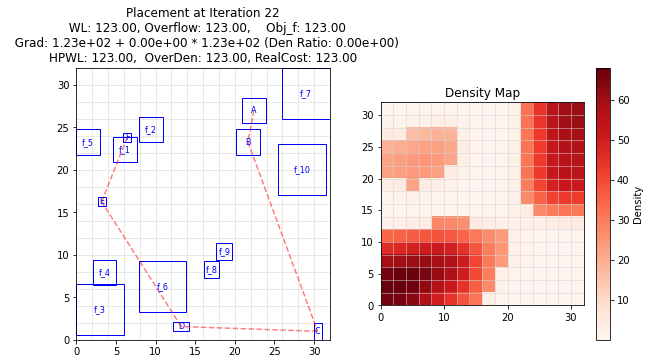

In [37]:
# Initialize random positions for cells (2D positions: x, y)
np.random.seed(666)  # For reproducibility
init_pos = initialize_placement(len(netlist.cells_name), board_size, netlist.cells_isfixed)
init_pos = bound_cells(init_pos)
netlist.cells_pos = init_pos.copy()
# Initialize bins expected potential
init_density_model()
update_potential_base()
smooth_base_potential()
update_exp_bin_potential(show_info=True)
# Visualization Check 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
costs_info = {"total_hpwl": 123, "total_lse": 123, "total_density_overflow": 123, "total_potential_overflow": 123, "total_obj_value": 123, "total_cost": 123, "weight_density": weight_density, "gWL": 123, "gPot": 123}
plot_placement(axs[0], board_size, netlist, iter, costs_info)
plot_density_map(fig, axs[1], board_size, bins_base_potential) # plot_density_map(axs[1], board_size, bins_density)
# display(fig)

In [ ]:
## Main analytical placement function ## 
# Initialize cells positions and parameters
netlist.cells_pos = init_pos.copy()
num_iter = ITER
gamma = GAMMA
step_size = LR

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# Iteratively optimize placement
for iter in range(num_iter):
    # Calculate Density
    compute_new_potential_grid()
    update_potential_grid()
    total_density_overflow, density_overflow_map, max_den = calculate_overflow_density()
    total_potential_overflow, potential_overflow_map, max_pot = calculate_overflow_potential()

    # Calculate gradient
    gradient = calculate_density_gradient() # actually here is calculate_potentail_gradient
    # Update positions
    netlist.cells_pos = update_positions(netlist.cells_pos, gradient, learning_rate=step_size, is_fixed=netlist.cells_isfixed)

    # Plot placement
    costs_info = {"total_hpwl": 123, "total_lse": 123, "total_density_overflow": total_density_overflow, "total_potential_overflow": total_potential_overflow, "total_obj_value": 123, "total_cost": total_density_overflow, "weight_density": 123, "gWL": 123, "gPot": 123}
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    plot_placement(axs[0], board_size, netlist, iter, costs_info)
    plot_density_map(fig, axs[1], board_size, bins_density)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.01)

## Better Gradient Descent

In [26]:
# CG (conjugate gradient) with Dynemic Step Size
# Compute β_k (Polak-Ribiere formula) with scaling to avoid overflow
def compute_beta_polak_ribiere_xy(grad, g_prev):
    """
    grad, g_prev: shape (N, 2)
    returns: beta: shape (N, 2)，對 x/y 各自計算 β
    """
    eps = 1e-10
    # Compute maximum absolute value for scaling to avoid overflow
    max_grad = np.maximum(np.max(np.abs(grad), axis=0), np.max(np.abs(g_prev), axis=0))
    max_grad = np.where(max_grad < eps, eps, max_grad)
    # Normalize the gradients
    grad_scaled = grad / max_grad
    g_prev_scaled = g_prev / max_grad
    # Numerator: g_k^T (g_k - g_{k-1})
    diff = grad_scaled - g_prev_scaled
    numerator = grad_scaled * diff
    # Denominator: g_{k-1}^T g_{k-1}
    denominator = g_prev_scaled ** 2 + eps
    denominator = np.where(denominator < eps, eps, denominator)  # avoid divide by 0
    # Beta: Polak-Ribiere formula
    beta = numerator / denominator  # element-wise (N,2)
    return beta
# Update cell positions
def update_positions_cg(cells_pos, g_prev, d_prev, grad, step_size=1.0, is_fixed=None):
    # (0) set movable mask
    if is_fixed is None:
        is_fixed = np.zeros(len(cells_pos), dtype=bool)
    is_fixed = is_fixed.astype(bool)
    movable_mask = ~is_fixed[:, None]  # shape: (N, 1)

    # (1) We have gradient directions grad = g_k = ∇f(x_k)
    # (2) Compute Polak-Ribiere parameter β_k (accelerate (sum) if gradient become better. slow down (subtract) if gradient become slower; go back (subtract very much) if gradient become bad)
    # beta = grad * (grad - g_prev) / np.sum(g_prev**2, axis=0)
    beta = compute_beta_polak_ribiere_xy(grad, g_prev)
    # beta = np.clip(beta, 0, None)  # make sure β_k >= 0
    # (3) Compute conjugate directions d = -grad + beta*d_prev
    dir = -grad + beta * d_prev # d_prev.shape = (N, 2)
    # (4) Compute step size alpha = s/norm(d)
    alpha = step_size / np.linalg.norm(dir, axis=0)
    # (5) update positions: x = x_prev + alpha*d
    cells_pos += (alpha * dir) * movable_mask
    return cells_pos, dir

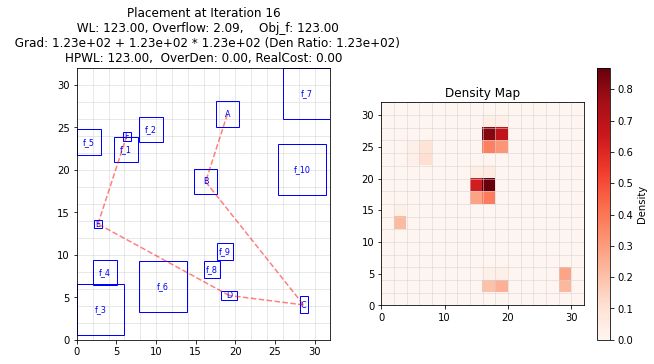

In [38]:
## Main analytical placement function ## 
# Initialize cells positions and parameters
netlist.cells_pos = init_pos.copy()
num_iter = ITER
gamma = GAMMA
step_size = board_size / 20

g_prev = np.zeros_like(netlist.cells_pos)  # init grad = 0
d_prev = np.zeros_like(netlist.cells_pos)  # init dir = 0
early_stop = False
# Iteratively optimize placement
for iter in range(num_iter):
    # Calculate Density
    compute_new_potential_grid()
    update_potential_grid()
    total_density_overflow, density_overflow_map, max_den = calculate_overflow_density()
    total_potential_overflow, potential_overflow_map, max_pot = calculate_overflow_potential()

    # Calculate gradient
    gradient = calculate_density_gradient() # actually here is calculate_potentail_gradient
    # Update positions
    netlist.cells_pos, dk = update_positions_cg(netlist.cells_pos, g_prev, d_prev, gradient, step_size=step_size, is_fixed=netlist.cells_isfixed)
    netlist.cells_pos = bound_cells(netlist.cells_pos) # bound cells to board size
    if iter > 15 and np.linalg.norm(gradient) > np.linalg.norm(g_prev):
        # print(f'Converged at iteration {iter}')
        early_stop = True
    g_prev = gradient.copy(); d_prev = dk.copy()


    # Plot placement
    costs_info = {"total_hpwl": 123, "total_lse": 123, "total_density_overflow": total_density_overflow, "total_potential_overflow": total_potential_overflow, "total_obj_value": 123, "total_cost": total_density_overflow, "weight_density": 123, "gWL": 123, "gPot": 123}
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), facecolor='white')
    plot_placement(axs[0], board_size, netlist, iter, costs_info)
    plot_density_map(fig, axs[1], board_size, bins_density)
    display(fig)
    clear_output(wait=True)
    plt.close(fig)
    plt.pause(0.01)

    if early_stop:
        break